<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/normalizing_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalizing Flows examples
In this notebook I've implemented the following normalizing and autoregressive flows: 
- Non-linear Independent Component Estimation (Dinh et al. 2015)
- Real-valided Non-Volume Preserving (Dinh et al. 2017)
- Masked Autoregressive Flow (Papmakarios et al. 2017)

This notebook is based on https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_04.ipynb

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
tfb = tfp.bijectors
tfd = tfp.distributions

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.11.0
TF  Version 2.3.0


In [3]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)
tf.random.set_seed(1)

## Lets start by generating some distribution

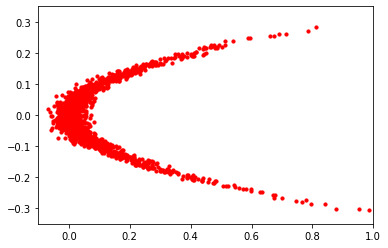

In [4]:
# Adapted from: https://blog.evjang.com/2018/01/nf1.html
def sample_2(batch_size=500):
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=tf.float32))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    return x_samples.numpy()/40.0

X = sample_2(1500)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.show()

## Building a NICE model
As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`. Having the variables in a model. Keras takes care of holding the variables.

```
y[0:d] = x[0:d] 
y[d:D] = x[d:D] + shift_fn(x[0:d])
```

This is super easy to invert
```
x[0:d] = y[0:d] 
x[d:D] = y[d:D] - shift_fn(x[0:d]) = y[d:D] - shift_fn(y[0:d])
```

For the `shift_fn`, I'll build a multi-layer neural network that takes in `d`-dimensional input and outputs `D-d` dimensional outputs. 

* NICE is a real NVP without the scale function.

In [5]:
class NICE(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.nets=[]

        # We need to keep track of the nets
        bijectors=[] # list of bijectors
        num_blocks = 5 # layers
        h = 32  # hidden layers
        for i in range(num_blocks): 
            # shift_fn
            net = tfb.real_nvp_default_template([h, h], shift_only=True)#D

            bijectors.append(
                tfb.RealNVP(shift_and_log_scale_fn=net, 
                            num_masked=num_masked))
            bijectors.append(tfb.Permute([1,0])) # Permutation of coordinates
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))

        self.flow = tfd.TransformedDistribution(# Distribution using z with two independent Gaussians
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)        

nice_model = NICE(output_dim=2, num_masked=1)

### Below is a bit magic stuff, concerning eager execution
#model.summary() #Yields an error. The model needs called before it is build.
_ = nice_model(X) 
print(nice_model.summary())

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Model: "nice"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5,765
Trainable params: 5,765
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

nice_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(nice_model.flow.log_prob(X)) 

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

start = time()
for i in range(max_epochs+1):
    loss = train_step(nice_model, nice_optimizer, X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
0   1.8557543 2.0943961143493652
100   1.8405614 0.5062265396118164
200   1.8404124 0.5141603946685791
300   1.840381 0.504185676574707
400   1.8403676 0.5207593441009521
500   1.8403534 0.4976778030395508
600   1.8403476 0.5177037715911865
700   1.8403437 0.5042691230773926
800   1.8403424 0.5049376487731934
900   1.8403378 0.5249526500701904
1000   1.8403387 0.5094928741455078
1100   1.8403424 0.5039272308349609
1200   1.8403333 0.5334038734436035
1300   1.8403362 0.516671895980835
1400   1.8403252 0.532233476638794
1500   1.8403255 0.5004279613494873
1600   1.8403236 0.5244259834289551
1700   1.8403227 0.5257444381713867
1800   1.8403201 0.54107666015625
1900   1.8403169 0.522625207901001
2000   1.8403212 0.5207376480102539
2100   1.8403157 0.5020930767059326
2200   1.8403155 0.5093843936920166
2300   1.8403195 0.5068519115447998
2400   1.8403172 0.4962596893310547
25

## Lets see how well NICE is able to reproduce the distribution


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.35, 0.35)

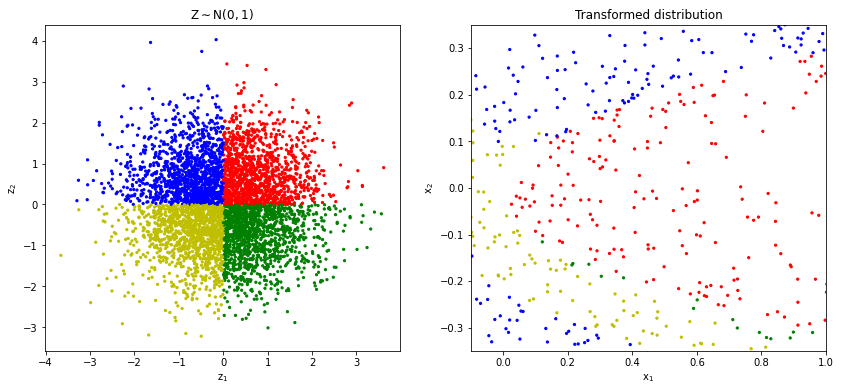

In [7]:
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = nice_model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)

## Building a RealNVP model
As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`. Having the variables in a model. Keras takes care of holding the variables.

```
y[0:d] = x[0:d] 
y[d:D] = x[d:D] * tf.exp(log_scale_fn(x[0:d])) + shift_fn(x[0:d])
```

This is super easy to invert
```
x[0:d] = y[0:d] 
x[d:D] = (y[d:D] - shift_fn(x[0:d])) * tf.exp(-log_scale_fn(x[0:d])) = (y[d:D] - shift_fn(y[0:d]))  * tf.exp(-log_scale_fn(y[0:d]))
```

For the `log_scale_fn` and `shift_fn`, I'll build multi-layer neural networks that take in `d`-dimensional input and outputs `D-d` dimensional outputs. 

In [8]:
class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, n_bijectors=5, hidden_layer=32, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.nets=[]

        permutation = tf.cast(np.concatenate((np.arange(self.output_dim / 2, self.output_dim), np.arange(0, self.output_dim / 2))),
                      tf.int32)

        # We need to keep track of the nets
        bijectors=[] 
        num_blocks = n_bijectors
        h = hidden_layer
        for i in range(num_blocks): 
            net = tfb.real_nvp_default_template([h, h])
            bijectors.append(
                tfb.RealNVP(shift_and_log_scale_fn=net, 
                            num_masked=num_masked))
            bijectors.append(tfb.Permute(permutation)) 
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0. for i in range(self.output_dim)]), 
            bijector=bijector)
        
    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    

nvp_model = RealNVP(output_dim=2, num_masked=1)
_ = nvp_model(X) 
print(nvp_model.summary())

Model: "real_nvp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5,930
Trainable params: 5,930
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
nvp_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
-tf.reduce_mean(nvp_model.flow.log_prob(X)) 

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(int(max_epochs+1)):
    loss = train_step(nvp_model, nvp_optimizer, X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   1.8997233 2.442667007446289
100   -1.7449665 0.7974262237548828
200   -2.4069586 0.7945208549499512
300   -2.7218082 0.796483039855957
400   -2.965561 0.7833461761474609
500   -3.0732825 0.7863919734954834
600   -3.1101599 0.7743756771087646
700   -3.1304262 0.7651784420013428
800   -3.1403847 0.7651712894439697
900   -3.1464388 0.7954998016357422
1000   -3.1516185 0.790062665939331
1100   -3.1552386 0.7827820777893066
1200   -3.158826 0.7795205116271973
1300   -3.1568406 0.8070955276489258
1400   -3.1638193 0.7853183746337891
1500   -3.1641586 0.789386510848999
1600   -3.165716 0.8109099864959717
1700   -3.1668057 0.7807657718658447
1800   -3.1690807 0.7899882793426514
1900   -3.1672585 0.781956672668457
2000   -3.168017 0.7806558609008789
2100   -3.171611 0.8051843643188477
2200   -3.1741157 0.7780137062072754
2300   -3.174085 0.7964341640472412
2400   -3.1721718 0.8120038509368896
2500   -3.1771328 0.7910006046295166
2600   -3.175388 0.784254789352417
2700   -3.1786618 0.7974393


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.35, 0.35)

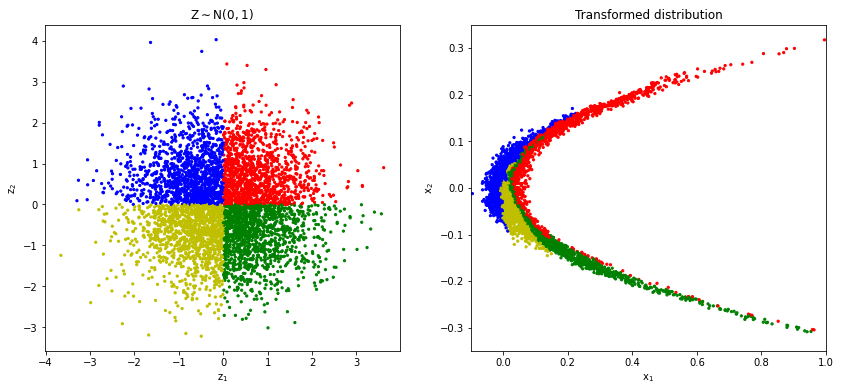

In [10]:
plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

Xs = nvp_model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)

# Masked Autoregressive Flow (MAF)

Unlike normalizing flow, which exploits change of variables, autoregressive flow exploits the chain rule of probability

$$p(x) = \prod\limits_{i=1}^D p(x_i|x_{0:i})$$


![](https://www.ritchievink.com/img/post-29-made/autoregessive-weights.png)

MAF uses the Masked Autoencoder for Distribution Estimation (MADE) architecture to enforce autoregressive property efficiently
![](https://www.ritchievink.com/img/post-29-made/masks-example.png)

```
y[0:d] = x[0:d] 
y[i] = x[i] * tf.exp(log_scale_fn(x[0:i])) + shift_fn(x[0:i])
```

**references**
- https://www.ritchievink.com/blog/2019/10/25/distribution-estimation-with-masked-autoencoders/


In [11]:
  class Mask_AR(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, n_bijectors=5, hidden_layer=32, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []

        permutation = tf.cast(np.concatenate((np.arange(self.output_dim / 2, self.output_dim), np.arange(0, self.output_dim / 2))),
                      tf.int32)

        # Defining the bijector
        bijectors=[] 
        num_blocks = n_bijectors
        h = hidden_layer
        for i in range(num_blocks): 
            # masked_autoregressive_default_template constructs a special network, 
            # which preserves the autoregressive property, called MADE.
            net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net))
            
            bijectors.append(tfb.Permute(permutation)) 
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0. for i in range(self.output_dim)]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)


maf_model = Mask_AR(output_dim=2, num_masked=1)
_ = maf_model(X) 
print(maf_model.summary())

Instructions for updating:
`masked_autoregressive_default_template` is deprecated; use `tfp.bijectors.AutoregressiveNetwork`.   Also, please note the section "Variable Tracking" in the documentation for `tfp.bijectors.MaskedAutoregressiveFlow`.
Model: "mask_ar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 6,420
Trainable params: 6,420
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
maf_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(maf_model.flow.log_prob(X)) 


@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(int(max_epochs+1)):
    loss = train_step(maf_model, maf_optimizer, X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   1.8623582 3.3893702030181885
100   -2.1464186 0.8434319496154785
200   -2.940568 0.86134934425354
300   -3.1293242 0.853217363357544
400   -3.1527872 0.8439681529998779
500   -3.1562464 0.849482536315918
600   -3.1604857 0.8475422859191895
700   -3.1588633 0.8469724655151367
800   -3.1627052 0.8625972270965576
900   -3.1572423 0.8828728199005127
1000   -3.1634715 0.8757586479187012
1100   -3.163056 0.8530075550079346
1200   -3.1622598 0.8608975410461426
1300   -3.1681113 0.840848445892334
1400   -3.1531165 0.8418929576873779
1500   -3.1650631 0.8423871994018555
1600   -3.1621978 0.8599398136138916
1700   -3.1666422 0.8462748527526855
1800   -3.1682904 0.8489561080932617
1900   -3.1652985 0.8665413856506348
2000   -3.1686661 0.8524169921875
2100   -3.1624713 0.8498775959014893
2200   -3.167916 0.8294506072998047
2300   -3.1680572 0.8550875186920166
2400   -3.157458 0.8419802188873291
2500   -3.172362 0.8643505573272705
2600   -3.1689634 0.8706116676330566
2700   -3.1680176 0.8612473


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.35, 0.35)

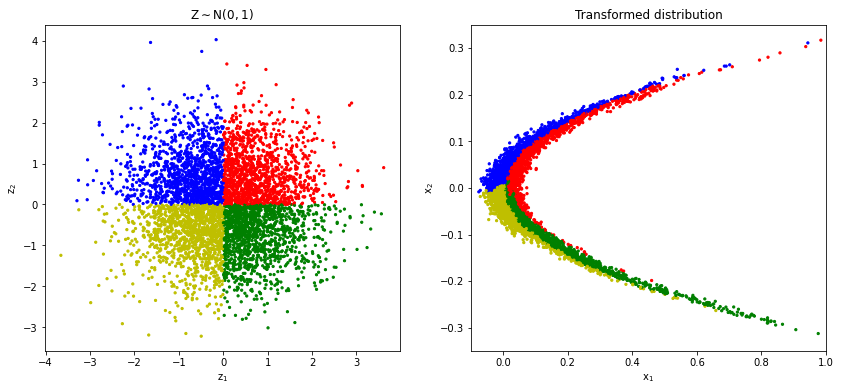

In [13]:
plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = maf_model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)


# higher dimensions

In [15]:
import corner as DFM

In [16]:
def sample_nd(batch_size=500, dimensions=3):
    x_dist = tfd.Normal(loc=0., scale=4.)
    x_samples = x_dist.sample(batch_size)

    x_list = [x_samples]

    for i in range(dimensions-1): 
      if i % 2 == 0: 
        _x = tfd.Normal(loc=.25 * tf.square(x_list[-1]),
                        scale=tf.ones(batch_size, dtype=tf.float32))
        _x_samples = _x.sample()
      else: 
        _x = tfd.Normal(loc=0., scale=4.)
        _x_samples = _x.sample(batch_size)
      x_list.append(_x_samples)

    x_samples = tf.stack(x_list, axis=1)
    return x_samples.numpy()/40.0

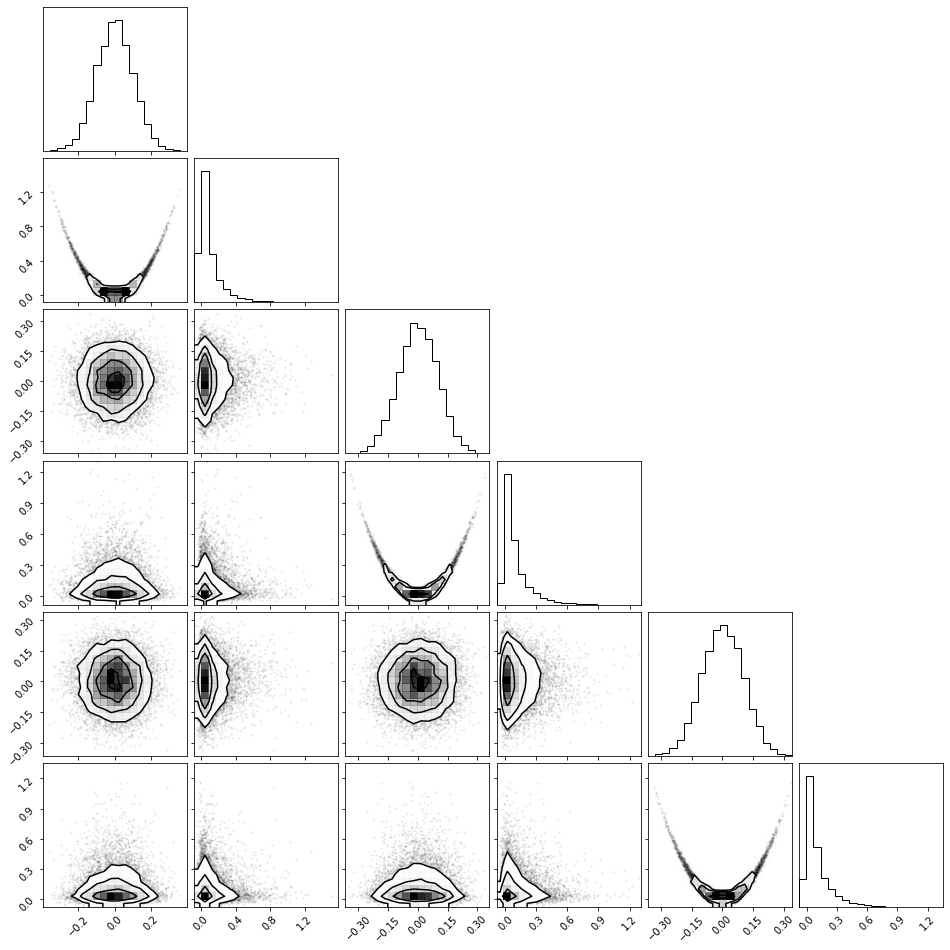

In [17]:
X_6D = sample_nd(10000, 6)
_ = DFM.corner(X_6D)

In [18]:
nvp_model = RealNVP(output_dim=6, num_masked=2)
_ = nvp_model(X_6D) 
print(nvp_model.summary())

Model: "real_nvp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 7,080
Trainable params: 7,080
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
nvp_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
-tf.reduce_mean(nvp_model.flow.log_prob(X_6D)) 

@tf.function 
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(int(1e3+1)):
    loss = train_step(nvp_model, nvp_optimizer, X_6D)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   -8.430908 2.7000317573547363
100   -8.454155 6.474844217300415
200   -8.4807 6.5328381061553955
300   -8.490297 6.2889649868011475
400   -8.453198 6.401038885116577
500   -8.461911 6.383620023727417
600   -8.53181 6.357502460479736
700   -8.5351095 6.749776363372803
800   -8.509532 6.532593727111816
900   -8.539346 6.45136570930481
1000   -8.555851 6.419596910476685


In [21]:
Z_6D = np.random.normal(0,1,(5000,6))
Xs_6D = nvp_model(Z_6D)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



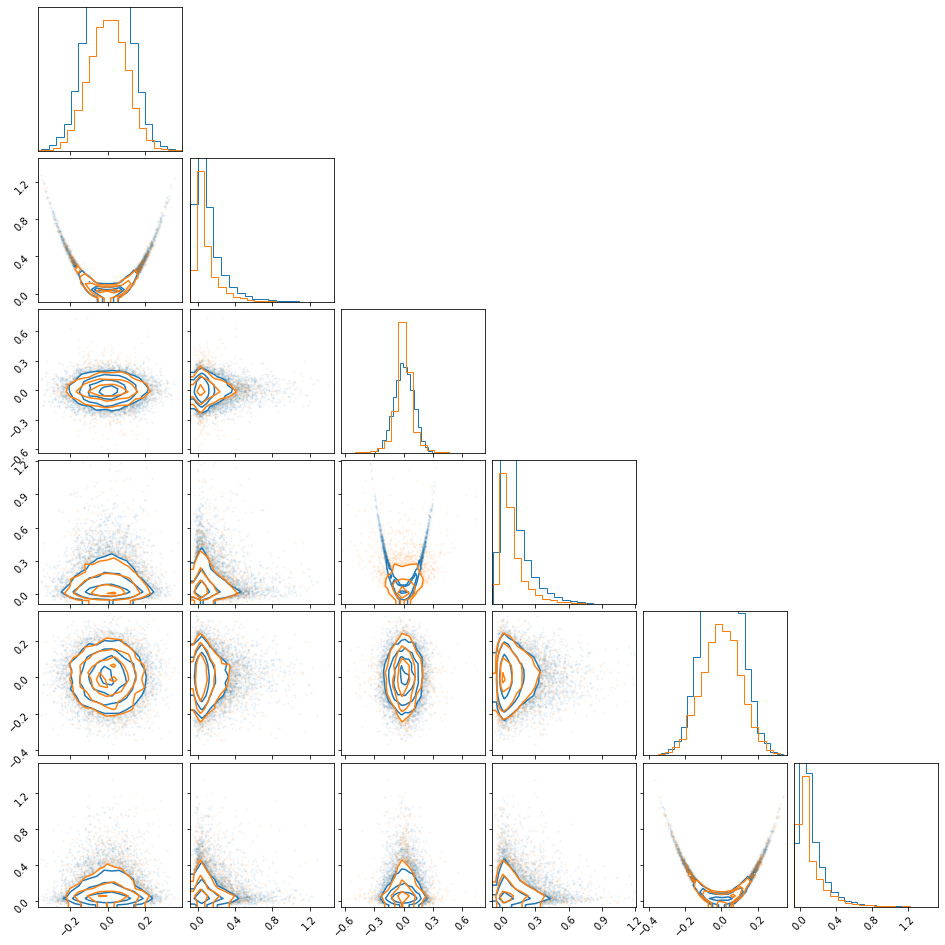

In [22]:
fig = DFM.corner(X_6D, plot_density=False, color='C0')
_ = DFM.corner(Xs_6D, plot_density=False, color='C1', fig=fig)

In [23]:
maf_model = Mask_AR(output_dim=6, num_masked=2, n_bijectors=5, hidden_layer=32)
_ = maf_model(X_6D) 
print(maf_model.summary())

Model: "mask_ar_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 8,380
Trainable params: 8,380
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
maf_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(maf_model.flow.log_prob(X_6D)) 


@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(int(1e3+1)):
    loss = train_step(maf_model, maf_optimizer, X_6D)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   5.525122 3.2193336486816406
100   -3.64785 7.297863006591797
200   -6.460874 7.3153040409088135
300   -7.5626225 7.26870059967041
400   -8.128211 7.289562463760376
500   -8.466209 7.508342504501343
600   -8.732655 7.837681531906128
700   -8.830047 7.5029518604278564
800   -9.009776 7.463744878768921
900   -9.082676 7.530119180679321
1000   -9.134281 7.503556728363037



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



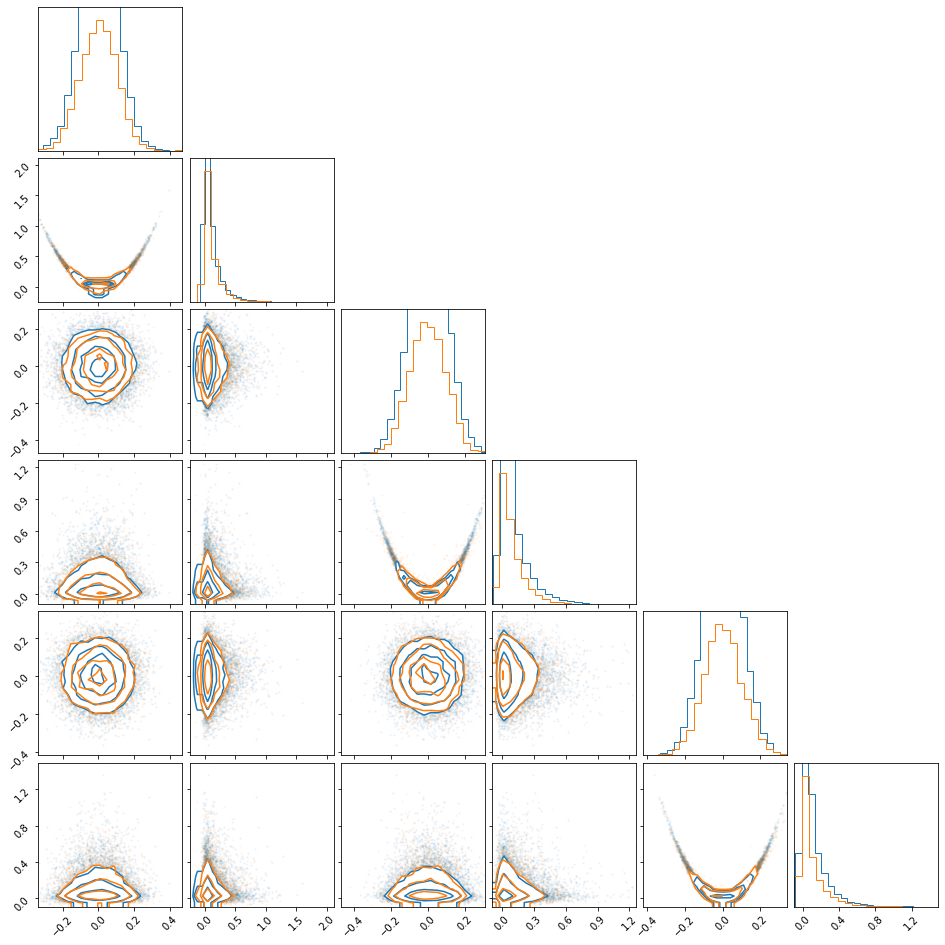

In [25]:
Z_6D = np.random.normal(0,1,(5000,6))
Xs_6D = maf_model(Z_6D)
fig = DFM.corner(X_6D, plot_density=False, color='C0')
_ = DFM.corner(Xs_6D, plot_density=False, color='C1', fig=fig)

In [26]:
maf_model = Mask_AR(output_dim=6, num_masked=2, n_bijectors=10, hidden_layer=100)
_ = maf_model(X_6D) 
print(maf_model.summary())

Model: "mask_ar_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 120,120
Trainable params: 120,120
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
maf_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(maf_model.flow.log_prob(X_6D)) 


@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(int(1e3+1)):
    loss = train_step(maf_model, maf_optimizer, X_6D)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   5.5427194 7.8475501537323
100   -7.07089 52.34706783294678
200   -8.95428 52.300171852111816
300   -9.388236 52.15531134605408
400   -9.462066 52.77281928062439
500   -9.476639 52.10904502868652
600   -9.5095415 52.23556137084961
700   -9.517114 52.23437976837158
800   -9.515247 53.24878144264221
900   -9.538081 53.894057273864746
1000   -9.532464 53.44007730484009



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



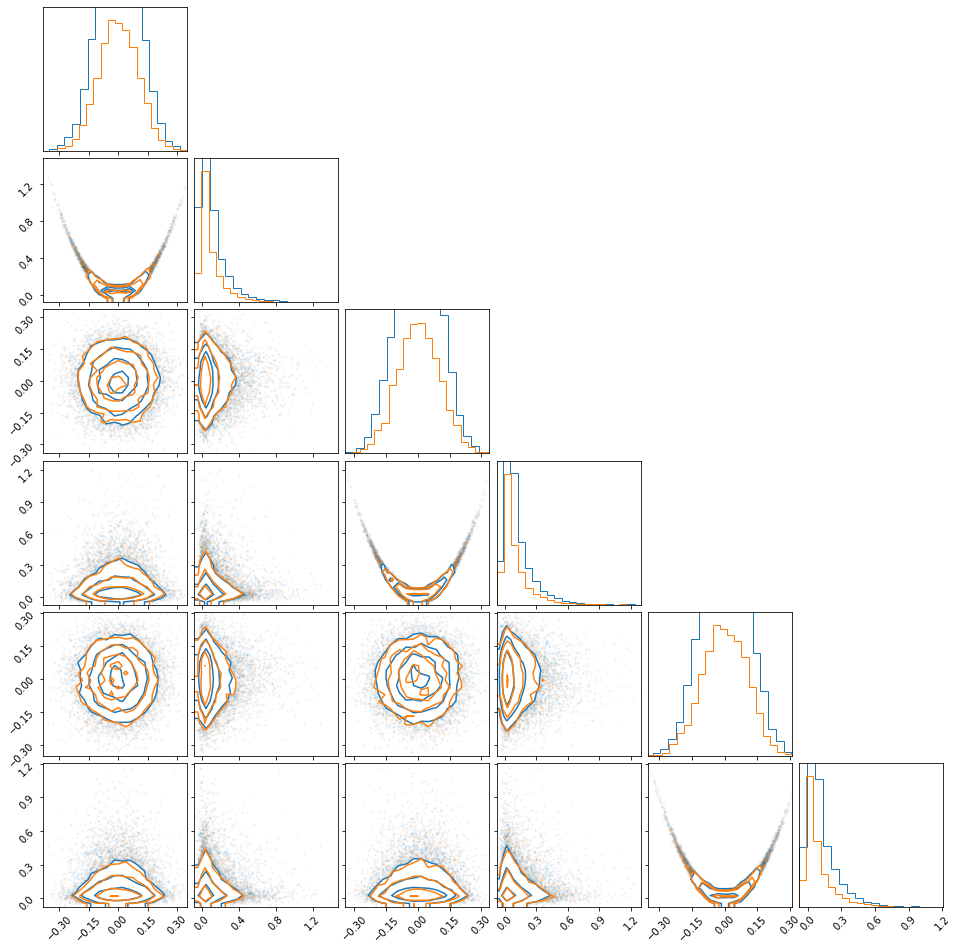

In [28]:
Z_6D = np.random.normal(0,1,(5000,6))
Xs_6D = maf_model(Z_6D)
fig = DFM.corner(X_6D, plot_density=False, color='C0')
_ = DFM.corner(Xs_6D, plot_density=False, color='C1', fig=fig)